<a href="https://colab.research.google.com/github/Deepakraj14-tamil/Leukemia-Data/blob/main/leukemia-82%25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
import pandas as pd
from tqdm import tqdm 
import tensorflow as tf

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential 
from keras.layers import BatchNormalization, Dropout, MaxPooling2D, Dense, Conv2D, Flatten, AveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, recall_score, precision_score, f1_score

In [3]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path="/content/drive/MyDrive/Blood-data/dataset2-master"
print(os.listdir(path))

['dataset2-master']


In [5]:
def loadData(folder):
    
    X = []
    y = []

    for label, subfolder in enumerate(['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']):         
        for imgFile in tqdm(os.listdir(os.path.join(folder, subfolder))):
            img_path = os.path.join(os.path.join(folder, subfolder), imgFile)
            image = cv2.imread(img_path)
            image = cv2.resize(image, [120,120])

            X.append(image/255.0)
            y.append(label)
            
    X = np.array(X, dtype = 'float32')
    y = np.array(y, dtype = 'int32')
    return X,y

In [6]:
X_train,y_train = loadData('/content/drive/MyDrive/Blood-data/dataset2-master/dataset2-master/images/TRAIN')

100%|██████████| 2499/2499 [00:53<00:00, 46.76it/s] 


In [7]:
X_test, y_test = loadData('/content/drive/MyDrive/Blood-data/dataset2-master/dataset2-master/images/TEST')

100%|██████████| 624/624 [00:12<00:00, 50.04it/s] 


In [8]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.7)

In [9]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [10]:
X_train, y_train = shuffle(X_train, y_train, random_state=616)

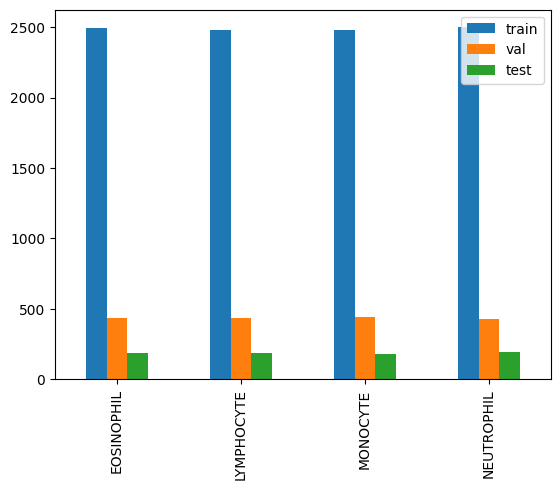

In [11]:
classNames = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

_, train_counts = np.unique(np.argmax(y_train,axis=1), return_counts = True)
_, val_counts = np.unique(np.argmax(y_val,axis=1), return_counts = True)
_, test_counts = np.unique(np.argmax(y_test,axis=1), return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = classNames).plot.bar()

plt.show()

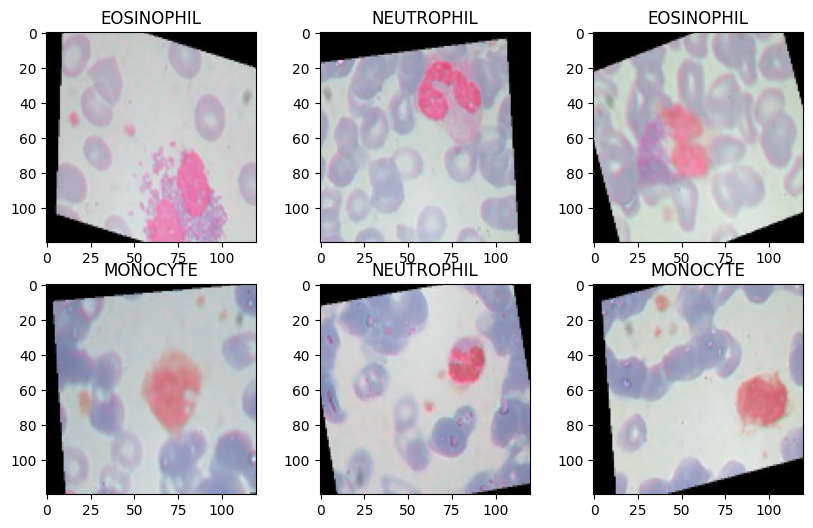

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_train[i])
    axi.set_title(classNames[y_train[i].argmax()])
plt.show()

In [22]:
model = Sequential()

# First Conv Layer
model.add(Conv2D(16 , (3,3) , activation = 'relu' , input_shape = (120,120,3)))
model.add(BatchNormalization())          
model.add(AveragePooling2D(pool_size = (2,2)))

# Second Conv Layer
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# Third Conv Layer
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# FC layer
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units = 4 , activation = 'softmax'))

# Compile
model.compile(optimizer = Adam(lr=0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 118, 118, 16)      448       
                                                                 
 batch_normalization_18 (Bat  (None, 118, 118, 16)     64        
 chNormalization)                                                
                                                                 
 average_pooling2d_18 (Avera  (None, 59, 59, 16)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_29 (Conv2D)          (None, 57, 57, 32)        4640      
                                                                 
 batch_normalization_19 (Bat  (None, 57, 57, 32)       128       
 chNormalization)                                                
                                                      

In [23]:
datagen = ImageDataGenerator(
  rotation_range=30,  # increased rotation range to 30 degrees
  width_shift_range=0.2,  # increased width shift range to 0.2
  height_shift_range=0.2,  # increased height shift range to 0.2
  shear_range=0.1,
  zoom_range=0.1,
  horizontal_flip=True,
  vertical_flip=True
)

In [24]:
checkpoint = ModelCheckpoint(
      filepath='model-{epoch:02d}-{val_accuracy:.2f}-train_acc-{accuracy:.2f}.h5',  # include training accuracy in the filename
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True)


In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
earlystop = EarlyStopping(
      monitor='val_accuracy',  # monitor validation accuracy
      patience=3, 
      restore_best_weights=True)

lrReduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    verbose=1, 
    factor=0.5,  # increase learning rate reduction factor to 0.5
    min_lr=0.00001)

In [31]:
history = model.fit(datagen.flow(X_train,y_train, batch_size=512),
                 epochs=10, validation_data = [X_val, y_val],callbacks=[lrReduction ,checkpoint])

Epoch 1/10
20/20 [==============================] - 259s 13s/step - loss: 0.2044 - accuracy: 0.8133 - val_loss: 0.6327 - val_accuracy: 0.6238 - lr: 0.0010
Epoch 2/10
20/20 [==============================] - 254s 13s/step - loss: 0.1724 - accuracy: 0.8443 - val_loss: 0.2497 - val_accuracy: 0.7926 - lr: 0.0010
Epoch 3/10
20/20 [==============================] - 251s 12s/step - loss: 0.1570 - accuracy: 0.8603 - val_loss: 0.2201 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 4/10
20/20 [==============================] - 256s 13s/step - loss: 0.1521 - accuracy: 0.8669 - val_loss: 0.1942 - val_accuracy: 0.7904 - lr: 0.0010
Epoch 5/10
20/20 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.8697 
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
20/20 [==============================] - 255s 13s/step - loss: 0.1456 - accuracy: 0.8697 - val_loss: 0.1969 - val_accuracy: 0.8076 - lr: 0.0010
Epoch 6/10
20/20 [==============================] - 255s 13s/step

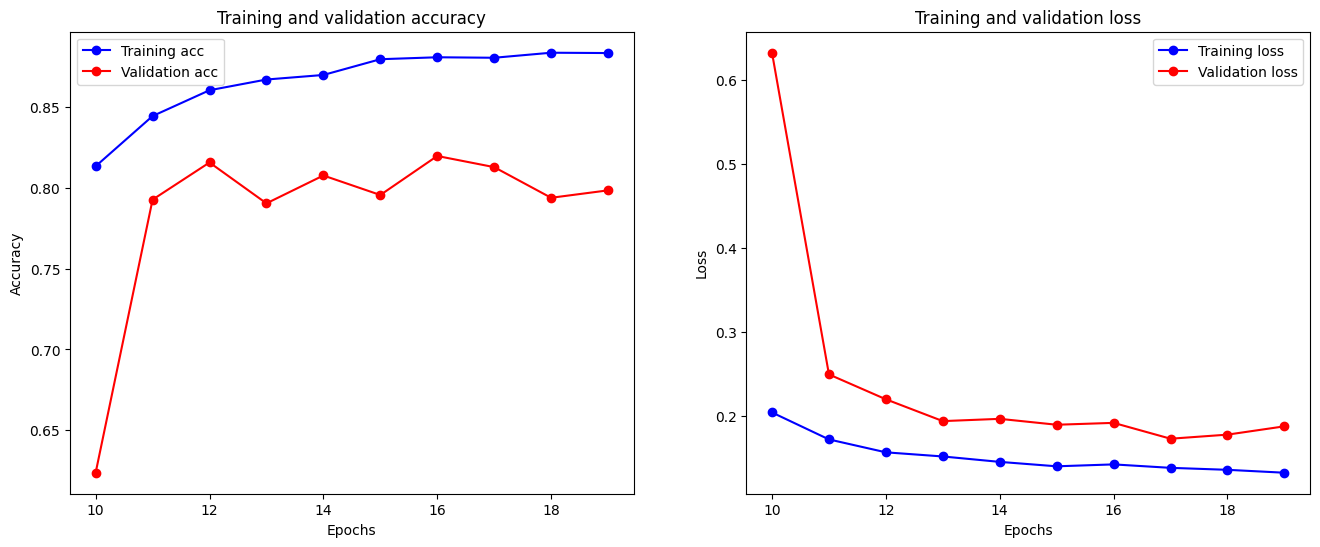

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(10, len(acc) + 10)

fig, axs = plt.subplots(1,2,figsize = (16,6))
axs[0].plot(epochs, acc, 'b-o', label='Training acc')
axs[0].plot(epochs, val_acc, 'r-o', label='Validation acc')
axs[0].set_title('Training and validation accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(epochs, loss, 'b-o', label='Training loss')
axs[1].plot(epochs, val_loss, 'r-o', label='Validation loss')
axs[1].set_title('Training and validation loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

In [33]:
y_pred = model.predict(X_test)
test_result = model.evaluate(X_test, y_test)

print("Loss of the model  is - test ", test_result[0])
print("Accuracy of the model is - test", test_result[1]*100, "%")

24/24 [==============================] - 4s 161ms/step - loss: 0.1699 - accuracy: 0.8204
Loss of the model  is - test  0.169932559132576
Accuracy of the model is - test 82.03753232955933 %


In [34]:
y_test_labels = np.argmax(y_test, axis = 1)
y_pred_labels = np.argmax(y_pred, axis = 1)

<Axes: >

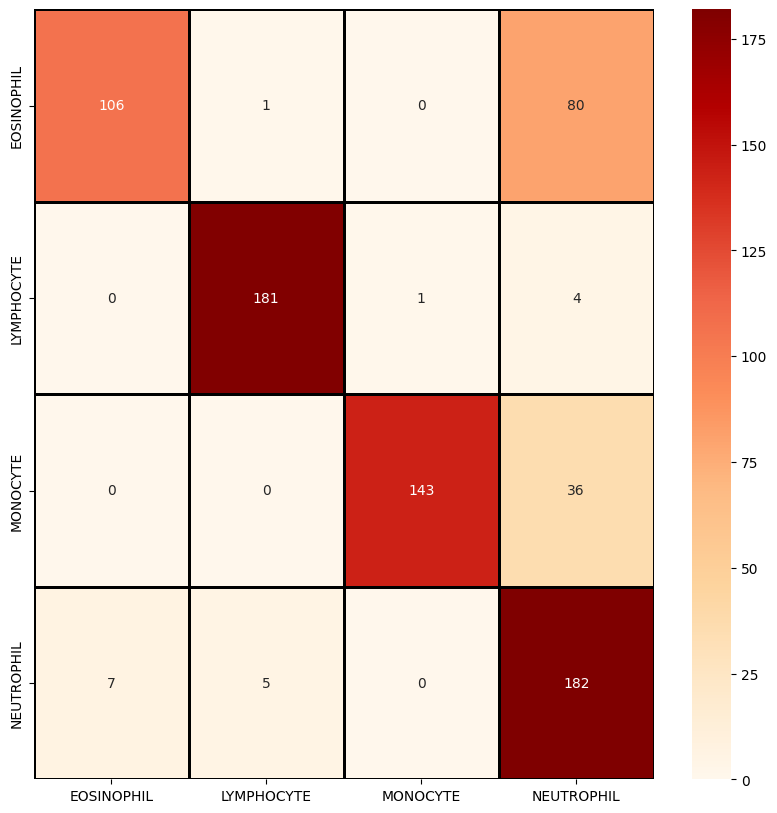

In [35]:
cm = confusion_matrix(y_test_labels, y_pred_labels)

classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

plt.figure(figsize = (10,10))
sns.heatmap(
    cm, 
    cmap = 'OrRd', 
    linecolor = 'black', 
    linewidth = 1, 
    annot = True, 
    fmt = '', 
    xticklabels = classes, 
    yticklabels = classes)

In [42]:
print("Recall of the model is - test", recall_score(y_test_labels, y_pred_labels, average='macro')*100)
print("Precision of the model is - test", precision_score(y_test_labels, y_pred_labels, average='macro')*100)
print("F1 score of the model is - test", f1_score(y_test_labels, y_pred_labels, average='macro')*100)

Recall of the model is - test 81.92475527042855
Precision of the model is - test 87.54180245064695
F1 score of the model is - test 82.41239835488217


In [43]:
y_pred = model.predict(X_test)

24/24 [==============================] - 4s 163ms/step


In [44]:
test_result = model.evaluate(X_test, y_test)

24/24 [==============================] - 4s 162ms/step - loss: 0.1699 - accuracy: 0.8204


In [45]:
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)
print("Confusion matrix:")
print(confusion_matrix(y_test_class, y_pred_class))
print("Classification report:")
print(classification_report(y_test_class, y_pred_class))


Confusion matrix:
[[106   1   0  80]
 [  0 181   1   4]
 [  0   0 143  36]
 [  7   5   0 182]]
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.57      0.71       187
           1       0.97      0.97      0.97       186
           2       0.99      0.80      0.89       179
           3       0.60      0.94      0.73       194

    accuracy                           0.82       746
   macro avg       0.88      0.82      0.82       746
weighted avg       0.87      0.82      0.82       746



In [46]:
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

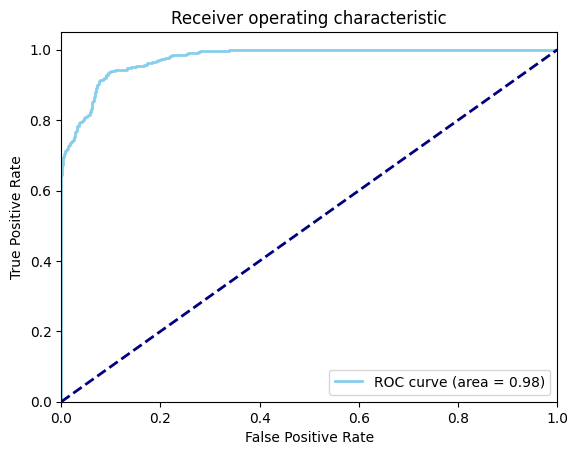

In [48]:
plt.figure()
plt.plot(fpr, tpr, color='skyblue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()